In [55]:
import matplotlib.pyplot as plt

import mapel.elections as mapel
from scripts.gurobi import gurobi_ilp

import scripts.experiments as experiments
import os

import numpy as np

import pickle
from scripts.basin_hopping import basin_hopping
from scripts.approvalwise_vector import get_approvalwise_vectors
from matplotlib import ticker


plt.rcParams['figure.dpi'] = 300

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Functions

In [3]:
import pandas as pd


def compare(reference_new_approvalwise_vectors, approvalwise_vectors, num_voters, num_generated, generator, experiment_id, id_scheme):
    reports = []
    new_approvalwise_vectorss = []

    for num_starting_elections in range(len(reference_new_approvalwise_vectors)):
        starting_approvalwise_vectors = [reference_new_approvalwise_vectors[id_scheme % i] for i in range(num_starting_elections)]
        new_approvalwise_vectors, report = experiments.generate_farthest_elections_l1_approvalwise(
            approvalwise_vectors + starting_approvalwise_vectors, num_voters, num_generated - num_starting_elections, generator, experiment_id)
        new_approvalwise_vectorss.append(new_approvalwise_vectors)
        reports.append(report)
    return reports, new_approvalwise_vectorss

def calculate_cumulative_proportional_vector(reference_distances: list[int], distancess: list[list[int]]) -> np.ndarray:
    distances_sums = [np.sum(distances) for distances in distancess]
    reference_distances  = np.array(reference_distances)
    reference_distances_sums = np.cumsum(reference_distances[::-1])[::-1]
    return distances_sums / reference_distances_sums

def split_reports_if_necessary(reports) -> list[pd.DataFrame]:
    if isinstance(reports, list):
        return reports
    all_num_starting_elections = reports.num_starting_elections.unique()
    return [
        reports[reports.num_starting_elections == num_starting_elections] for num_starting_elections in all_num_starting_elections
    ]

def plot_trajectories(reference_report, reports):
    plt.scatter(reference_report.experiment_size , reference_report.distance, label = "Gurobi")
    plt.plot(reference_report.experiment_size, reference_report.distance, '--')

    for idx, report in enumerate(reports):
        plt.scatter(report.experiment_size, report.distance, label=f'From {idx} gurobi elections')
        plt.plot(report.experiment_size, report.distance, '--')
        
    plt.legend()
    
def get_metric(reference_report, reports):
    return calculate_cumulative_proportional_vector(reference_report.distance, [report.distance for report in reports])

def plot_metric(metric):
    fig, ax = plt.subplots()

    ax.bar(np.arange(len(metric)), metric)
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(1))
    ax.set_ylim(0, 1)
    return fig, ax
        
    

# Content

In [5]:
num_generated = 10
num_candidates = 30
num_voters = 100
family_id = 'euclidean'
solver_id = 'gurobi'

experiment_id = f'{num_candidates}x{num_voters}/{family_id}'

results_dir = os.path.join('results', experiment_id, solver_id)

with open(os.path.join(results_dir, 'new-approvalwise-vectors.pkl'), 'rb') as f:
    gurobi_new_approvalwise_vectors = pickle.load(f) 

gurobi_report = pd.read_csv(os.path.join(results_dir, 'report.csv'))

In [7]:
len(gurobi_new_approvalwise_vectors)

14

In [8]:
# experiment = mapel.prepare_offline_approval_experiment(
#     experiment_id=experiment_id,
#     distance_id="l1-approvalwise",
#     embedding_id="fr"
# )
# experiment.prepare_elections()

id_scheme = f'NFE-{experiment_id}-%d'

# meaningful_elections = experiments.get_meaningful_elections(experiment.elections)
 
with open(os.path.join('experiments', experiment_id, 'elections.pkl'), 'rb') as file:
          meaningful_elections = pickle.load(file)
approvalwise_vectors = get_approvalwise_vectors(meaningful_elections)

In [9]:
# import pandas as pd
# from scripts.basin_hopping import __distance_across

# gurobi_distances = [__distance_across(approvalwise_vectors, np.array(x)) for x in gurobi_new_approvalwise_vectors.values()]
# gurobi_experiment_sizes = list(range(200, 200 + len(gurobi_new_approvalwise_vectors)))
# gurobi_report = pd.DataFrame({
#         'experiment_size': gurobi_experiment_sizes,
#         'distance': gurobi_distances
#     })

gurobi_report

,Unnamed: 0,experiment_size,execution_time,distance
0,0,36,6.579406,1483
1,1,37,20.649070,1133
2,2,38,25.857655,892
3,3,39,24.632945,888
4,4,40,897.242172,762
5,5,41,666.910198,722
6,6,42,918.787708,667
7,7,43,1093.983610,660
8,8,44,2793.861216,659
9,9,45,1786.933228,602


In [10]:
from scripts.approvalwise_vector import dump_to_text_file

with open(os.path.join(results_dir, 'approvalwise-vectors.txt'), 'w') as file:
    dump_to_text_file(approvalwise_vectors, num_voters, file)
    
with open(os.path.join(results_dir, 'new-approvalwise-vectors.txt'), 'w') as file:
    dump_to_text_file(gurobi_new_approvalwise_vectors, num_voters, file)


In [47]:
metrics = {}

# Basin hopping step_vector

In [49]:
generator = lambda approvalwise_vectors, num_voters: basin_hopping(
    approvalwise_vectors=approvalwise_vectors, 
    num_voters=num_voters, 
    step_size=7,  
    seed=2137, 
    big_step_chance=0.2,
    x0='step_vector'
)

reports, new_approvalwise_vectorss = compare(gurobi_new_approvalwise_vectors, approvalwise_vectors, num_voters, num_generated, generator, experiment_id, id_scheme)

Finding farthest elections:   0%|          | 0/10 [00:00<?, ?it/s]

Finding farthest elections: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


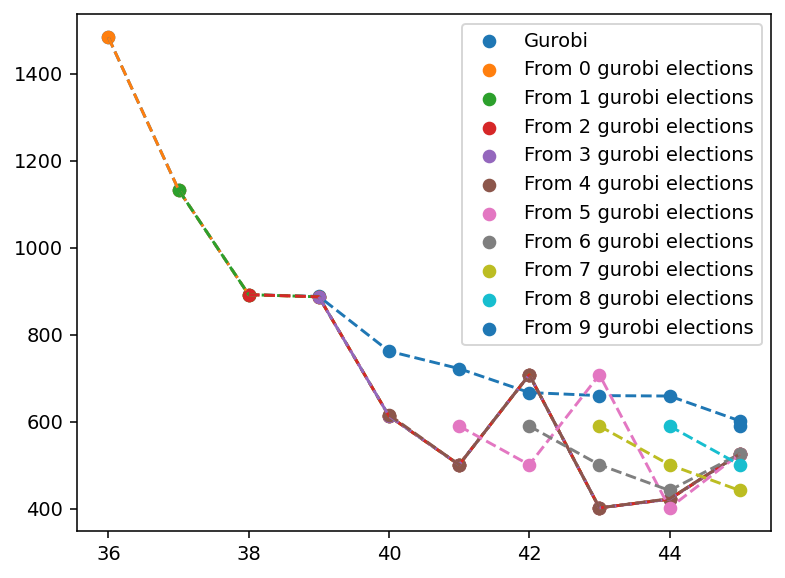

In [50]:
plot_trajectories(gurobi_report, reports)

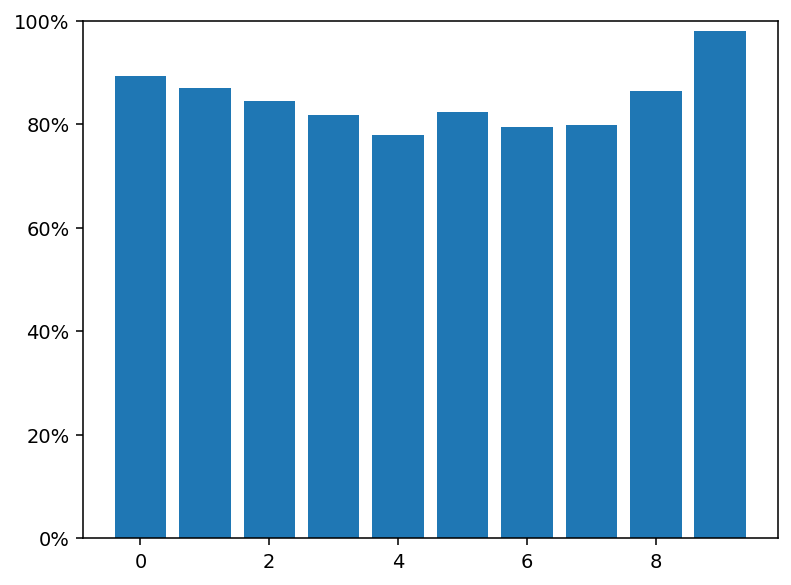

In [51]:
metric = get_metric(gurobi_report, reports)
plot_metric(metric)
metrics['basin_hopping_step_vector'] = metric

# Basin hopping random

In [52]:
generator = lambda approvalwise_vectors, num_voters: basin_hopping(
    approvalwise_vectors=approvalwise_vectors, 
    num_voters=num_voters, 
    step_size=7,  
    seed=2137, 
    big_step_chance=0.2,
    x0='random'
)

reports, new_approvalwise_vectorss = compare(gurobi_new_approvalwise_vectors, approvalwise_vectors, num_voters, num_generated, generator, experiment_id, id_scheme)

Finding farthest elections:   0%|          | 0/10 [00:00<?, ?it/s]

Finding farthest elections: 100%|██████████| 1/1 [00:01<00:00,  1.60s/it]


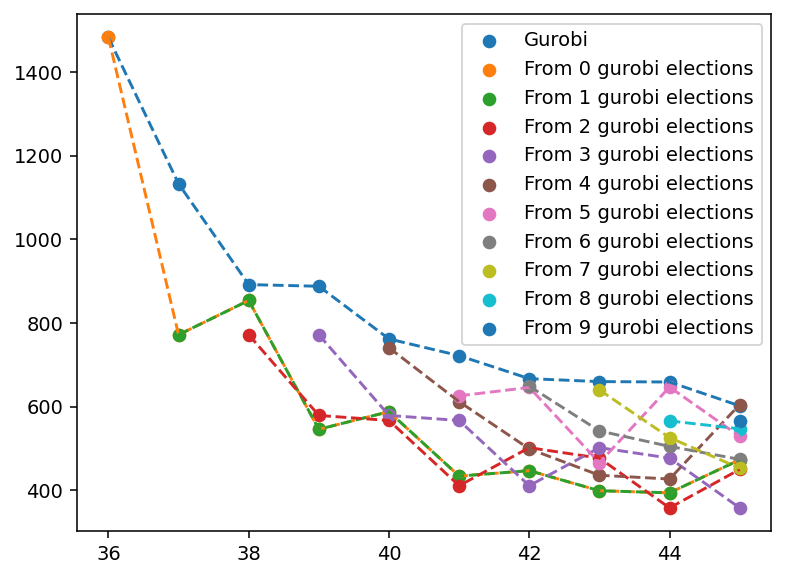

In [53]:
plot_trajectories(gurobi_report, reports)

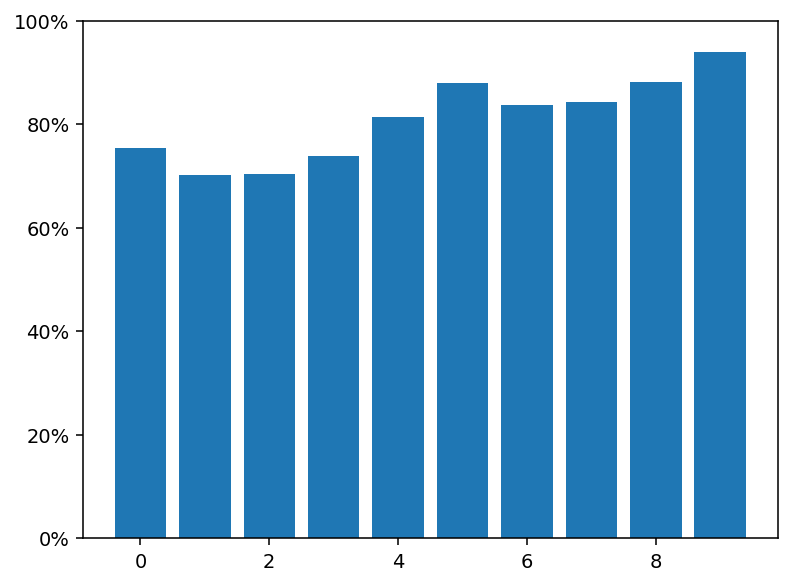

In [54]:
metric = get_metric(gurobi_report, reports)
plot_metric(metric)
metrics['basin_hopping_random'] = metric

# Greedy pairs 


In [55]:
from io import StringIO

# CSV String with out headers
csvString = """experiment_size,distance,execution_time,num_starting_elections
36,1483,2.26344,0
37,530,2.4225,0
38,1133,2.53769,0
39,674,2.70411,0
40,528,2.87123,0
41,500,2.94837,0
42,480,3.05797,0
43,395,3.25577,0
44,369,3.45783,0
45,328,3.75275,0
37,530,2.43692,1
38,1133,2.52716,1
39,674,2.67502,1
40,528,2.77842,1
41,500,2.95946,1
42,480,3.09915,1
43,395,3.21397,1
44,369,3.42611,1
45,328,4.03124,1
38,720,2.65355,2
39,831,2.65874,2
40,427,2.76846,2
41,578,2.90682,2
42,560,3.06015,2
43,423,3.31744,2
44,406,3.4415,2
45,335,3.57694,2
39,720,2.66085,3
40,427,2.8346,3
41,600,3.25422,3
42,578,3.07055,3
43,406,3.23481,3
44,386,3.68448,3
45,301,3.81623,3
40,633,2.82545,4
41,645,2.949,4
42,522,3.13732,4
43,419,3.23719,4
44,410,3.37668,4
45,390,3.53175,4
41,633,2.90954,5
42,583,3.07327,5
43,553,3.21817,5
44,522,3.3631,5
45,421,3.52844,5
42,633,3.06113,6
43,553,3.21291,6
44,522,3.36556,6
45,464,3.59479,6
43,633,3.20695,7
44,522,3.37001,7
45,464,3.52672,7
44,633,3.36341,8
45,522,3.52707,8
45,523,3.52896,9"""

# Convert String into StringIO
csvStringIO = StringIO(csvString)
reports = split_reports_if_necessary(pd.read_csv(csvStringIO))

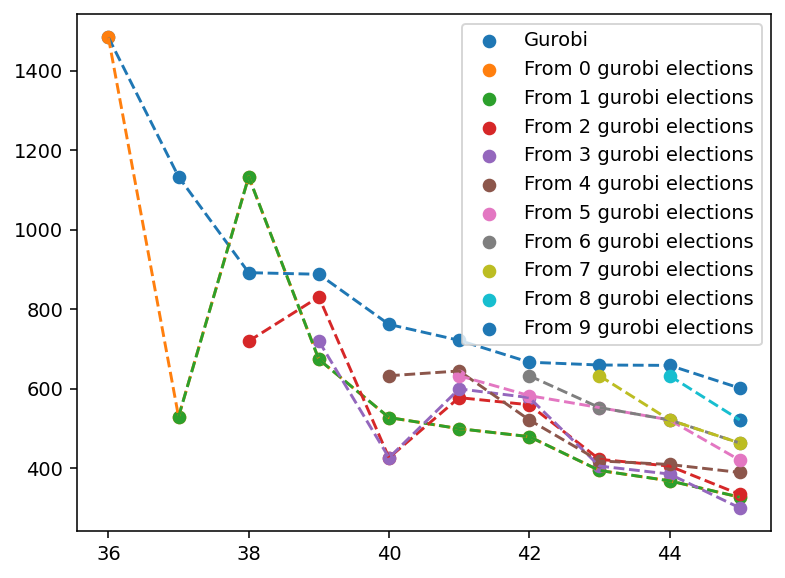

In [56]:
plot_trajectories(gurobi_report, reports)

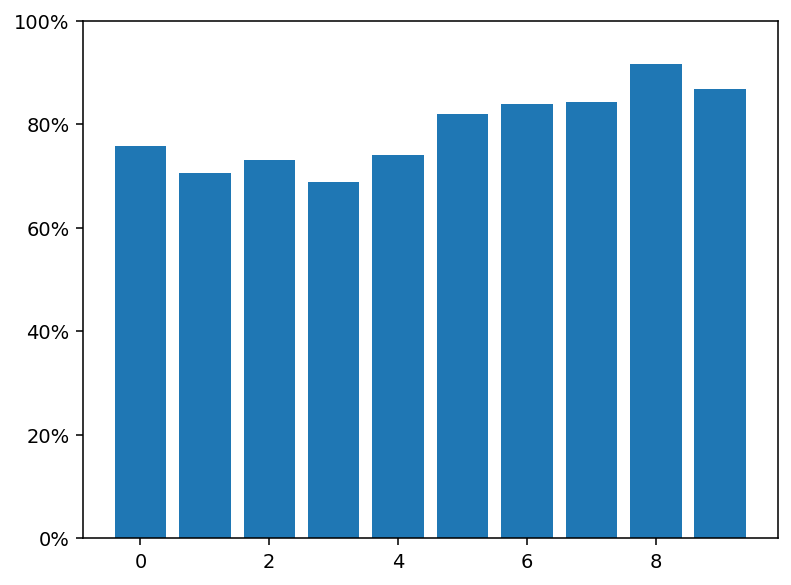

In [57]:
metric = get_metric(gurobi_report, reports)
plot_metric(metric)
metrics['greedy_pairs'] = metric

In [58]:
csvString = """experiment_size,distance,execution_time,num_starting_elections
36,1483,0.085185,0
37,772,0.069319,0
38,593,0.070341,0
39,505,0.073088,0
40,592,0.075759,0
41,583,0.077473,0
42,471,0.078772,0
43,460,0.081155,0
44,449,0.083039,0
45,374,0.083718,0
37,772,0.068653,1
38,593,0.069808,1
39,505,0.073539,1
40,592,0.075766,1
41,583,0.077777,1
42,471,0.079639,1
43,460,0.081656,1
44,449,0.082139,1
45,374,0.084032,1
38,772,0.07062,2
39,593,0.071888,2
40,505,0.074007,2
41,592,0.077097,2
42,584,0.078471,2
43,466,0.080527,2
44,461,0.082193,2
45,459,0.084744,2
39,773,0.072618,3
40,495,0.074665,3
41,484,0.076997,3
42,651,0.080006,3
43,508,0.081259,3
44,510,0.083257,3
45,462,0.085038,3
40,669,0.075218,4
41,526,0.077417,4
42,592,0.079461,4
43,621,0.081922,4
44,446,0.084042,4
45,409,0.085004,4
41,622,0.077446,5
42,525,0.079213,5
43,464,0.081858,5
44,507,0.083879,5
45,475,0.085183,5
42,639,0.078796,6
43,501,0.081941,6
44,532,0.082901,6
45,457,0.085138,6
43,529,0.080774,7
44,489,0.08329,7
45,450,0.084815,7
44,509,0.083601,8
45,587,0.084417,8
45,461,0.085919,9"""

# Convert String into StringIO
csvStringIO = StringIO(csvString)
reports = split_reports_if_necessary(pd.read_csv(csvStringIO))

Text(0.5, 1.0, 'Farthest elections for gurobi')

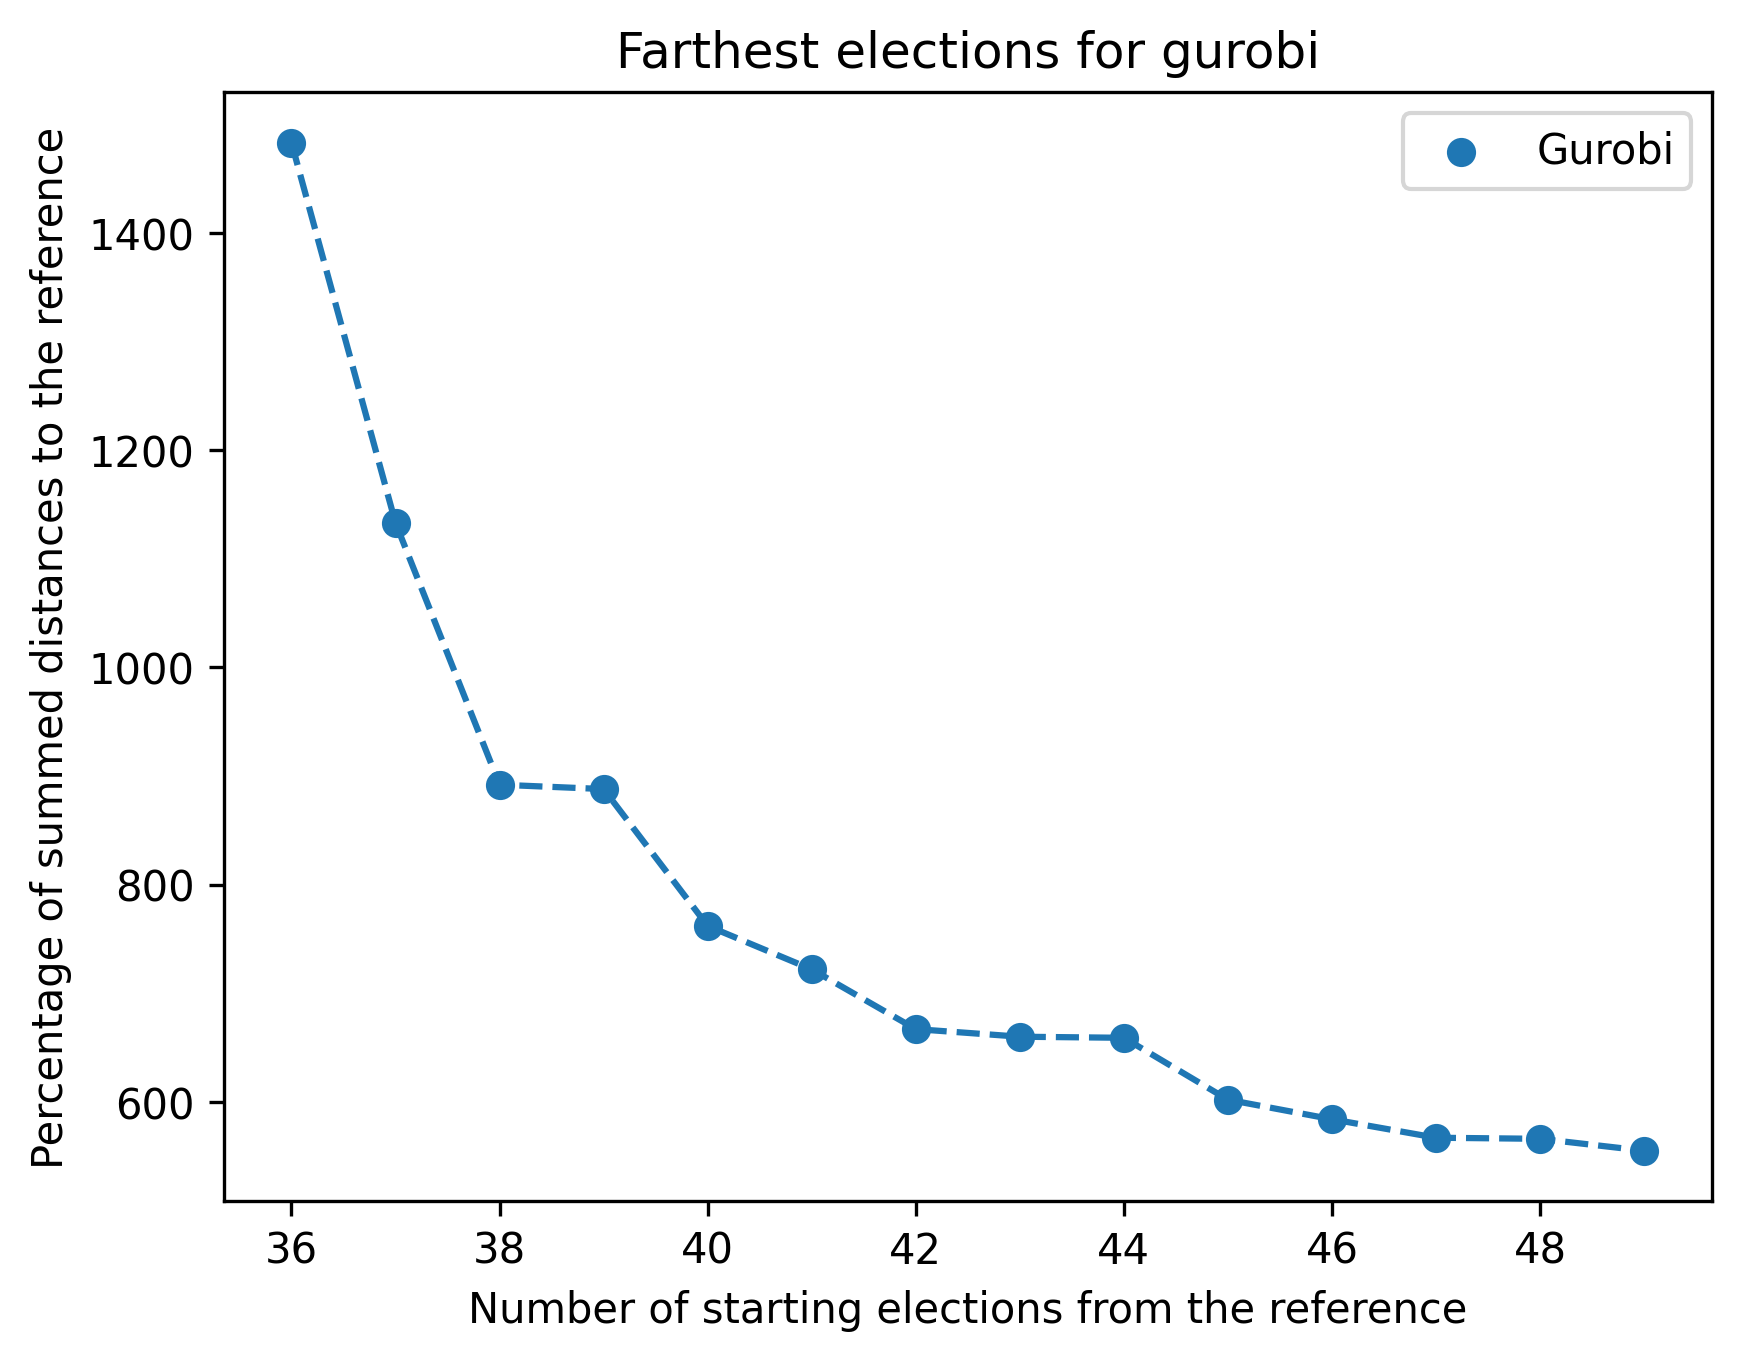

In [56]:
plot_trajectories(gurobi_report, [])
plt.xlabel('Number of starting elections from the reference')
plt.ylabel('Percentage of summed distances to the reference')
plt.title(f'Farthest elections for gurobi')

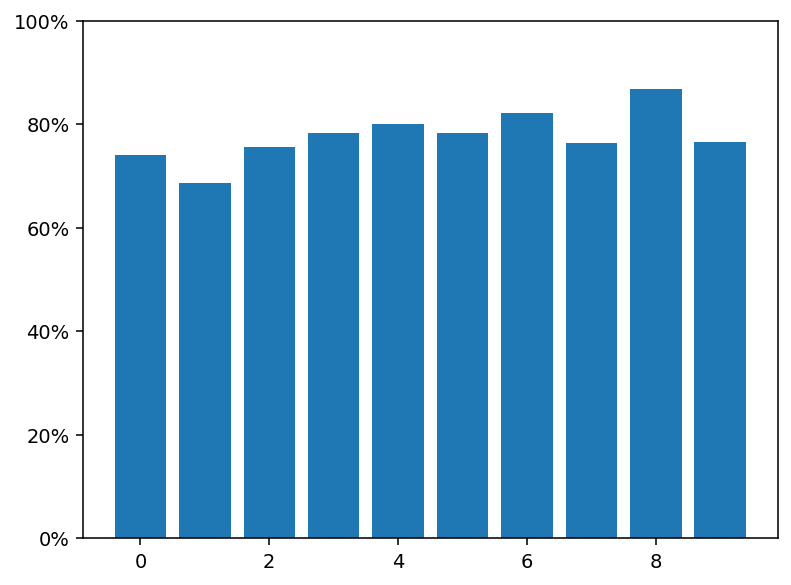

In [60]:
metric = get_metric(gurobi_report, reports)
plot_metric(metric)
metrics['greedy_dp'] = metric

In [62]:
pd.DataFrame(metrics)

,basin_hopping_step_vector,basin_hopping_random,greedy_pairs,greedy_dp
0,0.893599,0.754606,0.758148,0.741852
1,0.871009,0.702505,0.706800,0.687044
2,0.846036,0.703349,0.731374,0.757348
3,0.818347,0.739113,0.689113,0.782863
4,0.779961,0.815324,0.741405,0.801326
5,0.823867,0.880363,0.819335,0.783384
6,0.795595,0.838485,0.839258,0.822643
7,0.798022,0.842790,0.842790,0.764185
8,0.865186,0.882633,0.915940,0.869151
9,0.980066,0.940199,0.868771,0.765781


In [14]:
results_dir

'results/30x100/euclidean/gurobi'

In [15]:
solvers_ids = [
    'basin_hopping', 'basin_hopping_random', 'pairs', 'greedy_dp'
]

reports = [pd.read_csv(file) for file in [os.path.join('results/30x100/euclidean/', solver_id, 'report.csv') for solver_id in solvers_ids]]

In [48]:
to_join = []

for report, solver_id in zip(reports, solvers_ids):
    report['solver'] = solver_id
    to_join.append(report)
    
report = pd.concat(to_join)

In [26]:
report = report.groupby(['solver', 'num_starting_elections']).sum().reset_index()
times = {solver_id: list(report[report.solver == solver_id].execution_time) for solver_id in solvers_ids}
times['num_starting_elections'] = list(range(14))
times['gurobi'] = np.cumsum(np.array(gurobi_report['execution_time'])[::-1])[::-1]
pd.DataFrame(times)[['num_starting_elections', 'gurobi', 'basin_hopping',	'basin_hopping_random',	'pairs',	'greedy_dp']]


In [51]:
report = report.groupby(['solver', 'num_starting_elections']).sum().reset_index()
gurobi = np.cumsum(np.array(gurobi_report['distance'])[::-1])[::-1]
times = {solver_id: np.array(report[report.solver == solver_id].distance) / gurobi for solver_id in solvers_ids}
times['gurobi'] = 1
times['num_starting_elections'] = list(range(14))
pd.DataFrame(times)[['num_starting_elections', 'gurobi', 'basin_hopping',	'basin_hopping_random',	'pairs',	'greedy_dp']]


,num_starting_elections,gurobi,basin_hopping,basin_hopping_random,pairs,greedy_dp
0,0,1,0.856704,0.756704,0.727002,0.739013
1,1,1,0.833747,0.717727,0.683267,0.697202
2,2,1,0.810561,0.695716,0.679345,0.759970
3,3,1,0.787196,0.729397,0.643805,0.775581
4,4,1,0.750946,0.772383,0.696564,0.787989
5,5,1,0.827481,0.832676,0.775170,0.774633
6,6,1,0.818519,0.837449,0.779630,0.794856
7,7,1,0.835917,0.817076,0.758407,0.752683
8,8,1,0.818851,0.904614,0.802717,0.829040
9,9,1,0.849339,0.890049,0.795059,0.748434


array([26482.2239759 , 26475.64456964, 26454.99549961, 26429.1378448 ,
       26404.50490022, 25507.26272774, 24840.35253   , 23921.56482244,
       22827.58121204, 20033.71999574, 18246.78676724, 11965.77339602,
        6516.23757243,  3245.92167377])